In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score


In [2]:
tokenizer_fr = AutoTokenizer.from_pretrained("ulrichING/bert-base-sentiment-analysis-french")
model_fr = AutoModelForSequenceClassification.from_pretrained("ulrichING/bert-base-sentiment-analysis-french")

In [3]:
tokenizer_multi_lang = AutoTokenizer.from_pretrained("tabularisai/multilingual-sentiment-analysis")
model_multi_lang = AutoModelForSequenceClassification.from_pretrained("tabularisai/multilingual-sentiment-analysis")

In [4]:
tokenizer_multi_lang_unca = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model_multi_lang_unca = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

In [5]:
column_names = ['class', 'id', 'date', 'query', 'name', 'tweet']
#df = pd.read_csv("dataSet140.csv", sep=',', encoding='ISO-8859-1',names=column_names)

In [6]:
#train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

#print("Training set shape:", train_df.shape)
#print("Test set shape:", test_df.shape)

In [7]:
testFr_df = pd.read_csv("sentiment140_postif-negatif.csv")

In [8]:
testFr_df.head()

,class,id,date,query,name,tweet,tweet_fr
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","@switchfoot http://twitpic.com/2y1zl - Awww, c..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,est contrarié qu'il ne puisse pas mettre à jou...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,@Kenichan J'ai plongé plusieurs fois pour la b...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,Tout mon corps se sent démangeant et comme sur...
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....","@nationwideclass non, ce n'est pas du tout se ..."


Test du model bert-base-sentiment-analysis-french

In [9]:
def tweet_test_fr(logits):
    rep = logits.tolist()
    rep = rep[0]
    indice_max = rep.index(max(rep)) + 1
    if indice_max == 1 :
        return 0
    else :
        return 4

In [10]:
def cleanText(text):
    clean_text = re.sub(r'@\w+|http\S+', '', text)
    return clean_text.strip()

In [11]:
def test_fr_modelFR(df):
    count = 0
    df_cleaned = df.loc[:, "tweet_fr"] = df["tweet_fr"].apply(cleanText)
    ans = []
    for item in df_cleaned:
        text = item
        inputs = tokenizer_fr(text, return_tensors="pt")

        with torch.no_grad():
            outputs = model_fr(**inputs)

        logits = outputs.logits
        predicted_class = torch.argmax(logits).item()

        print(text)
        print(f"Raw logits: {logits}")
        print(f"Predicted sentiment class: {predicted_class + 1} (1 = worst, 2 = best)")
        count+=1
        print(count)
        ans.append(tweet_test_fr(logits))
    return ans

In [12]:
def test_eng_modelFR(df):
    count = 0
    df_cleaned = df.loc[:, "tweet"] = df["tweet"].apply(cleanText)
    ans = []
    for item in df_cleaned:
        text = item
        inputs = tokenizer_fr(text, return_tensors="pt")

        with torch.no_grad():
            outputs = model_fr(**inputs)

        logits = outputs.logits
        predicted_class = torch.argmax(logits).item()

        print(text)
        print(f"Raw logits: {logits}")
        print(f"Predicted sentiment class: {predicted_class + 1} (1 = worst, 2 = best)")
        count+=1
        print(count)
        ans.append(tweet_test_fr(logits))
    return ans

In [13]:
ansFR_modelFR = test_fr_modelFR(testFr_df[:1000])

- Awww, c'est nul. Vous devriez avoir David Carr du troisième jour pour le faire. ;D
Raw logits: tensor([[ 2.7499, -3.0040]])
Predicted sentiment class: 1 (1 = worst, 2 = best)
1
est contrarié qu'il ne puisse pas mettre à jour son Facebook en le texto... et pourrait pleurer en conséquence École aujourd'hui aussi.
Raw logits: tensor([[ 0.7369, -0.9678]])
Predicted sentiment class: 1 (1 = worst, 2 = best)
2
J'ai plongé plusieurs fois pour la balle. A réussi à économiser 50% Le reste sortir des limites
Raw logits: tensor([[ 1.2366, -1.4728]])
Predicted sentiment class: 1 (1 = worst, 2 = best)
3
Tout mon corps se sent démangeant et comme sur le feu
Raw logits: tensor([[-0.4242,  0.2913]])
Predicted sentiment class: 2 (1 = worst, 2 = best)
4
non, ce n'est pas du tout se comporter. Je suis fou. Pourquoi suis-je ici? Parce que je ne peux pas vous voir partout là-bas.
Raw logits: tensor([[ 0.2254, -0.4131]])
Predicted sentiment class: 1 (1 = worst, 2 = best)
5
pas tout l'équipage
Raw logits: t

In [14]:
ans1 = 0
for actual, predicted in zip(testFr_df["class"], ansFR_modelFR):
    if actual == predicted:
        ans1 += 1

accuracy1 = ans1 / testFr_df[:1000].shape[0]
print(accuracy1)


0.566


In [15]:
f1 = f1_score(testFr_df["class"][:1000], ansFR_modelFR[:1000], average="weighted")
print("F1-score:", f1)

F1-score: 0.49365080105843323


In [16]:
precision = precision_score(testFr_df["class"][:1000], ansFR_modelFR[:1000], average="weighted")
print("Precision:", precision)

Precision: 0.6540386123454945


In [17]:
ans_eng_modelFR = test_eng_modelFR(testFr_df[:1000])

- Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
Raw logits: tensor([[ 0.2414, -0.2215]])
Predicted sentiment class: 1 (1 = worst, 2 = best)
1
is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
Raw logits: tensor([[ 0.0967, -0.0207]])
Predicted sentiment class: 1 (1 = worst, 2 = best)
2
I dived many times for the ball. Managed to save 50%  The rest go out of bounds
Raw logits: tensor([[ 0.7267, -1.0016]])
Predicted sentiment class: 1 (1 = worst, 2 = best)
3
my whole body feels itchy and like its on fire
Raw logits: tensor([[0.0604, 0.1636]])
Predicted sentiment class: 2 (1 = worst, 2 = best)
4
no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.
Raw logits: tensor([[ 0.4303, -0.4907]])
Predicted sentiment class: 1 (1 = worst, 2 = best)
5
not the whole crew
Raw logits: tensor([[ 0.3306, -0.3905]])
Predicted sentiment class: 1 (1 = worst, 2 = best)
6
Need a 

In [18]:
ans2 = 0
for actual, predicted in zip(testFr_df["class"], ans_eng_modelFR):
    if actual == predicted:
        ans2 += 1

accuracy2 = ans2 / testFr_df[:1000].shape[0]
print(accuracy2)

0.505


In [19]:
f1 = f1_score(testFr_df["class"][:1000], ans_eng_modelFR[:1000], average="weighted")
print("F1-score:", f1)

F1-score: 0.42094359288708166


In [20]:
precision = precision_score(testFr_df["class"][:1000], ans_eng_modelFR[:1000], average="weighted")
print("Precision:", precision)

Precision: 0.5119230439054169


In [21]:
def affichage(ans1, ans2):
    labels = ['test français', 'test anglais']
    values = [ans1, ans2]

    plt.bar(labels, values, color=['blue', 'red'])

    plt.title('Comparaison')
    plt.xlabel('Values')
    plt.ylabel('%')

    plt.ylim(0, 1)

    plt.show()

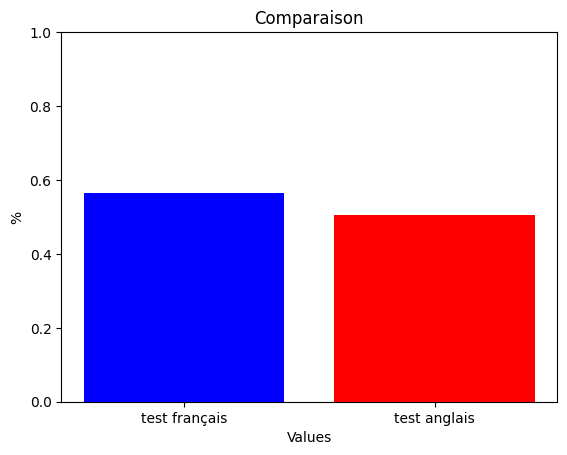

In [22]:
affichage(accuracy1, accuracy2)

Test du model multilingual-sentiment-analysis

In [23]:
def tweet_test_multilang(logits):
    rep = logits.tolist()
    rep = rep[0]
    indice_max = rep.index(max(rep)) + 1
    if 0<= indice_max <= 2 :
        return 0
    else :
        return 4

In [24]:
def test_multilang_eng(df):
    count = 0
    df_cleaned = df.loc[:, "tweet"] = df["tweet"].apply(cleanText)
    ans = []
    for item in df_cleaned:
        text = item
        inputs = tokenizer_multi_lang(text, return_tensors="pt")

        with torch.no_grad():
            outputs = model_multi_lang(**inputs)

        logits = outputs.logits
        predicted_class = torch.argmax(logits).item()

        print(text)
        print(f"Raw logits: {logits}")
        print(f"Predicted sentiment class: {predicted_class + 1} (1 = worst, 5 = best)")
        count+=1
        print(count)
        ans.append(tweet_test_multilang(logits))
    return ans

In [25]:
def test_multilang_fr(df):
    count = 0
    df_cleaned = df.loc[:, "tweet_fr"] = df["tweet_fr"].apply(cleanText)
    ans = []
    for item in df_cleaned:
        text = item
        inputs = tokenizer_multi_lang(text, return_tensors="pt")

        with torch.no_grad():
            outputs = model_multi_lang(**inputs)

        logits = outputs.logits
        predicted_class = torch.argmax(logits).item()

        print(text)
        print(f"Raw logits: {logits}")
        print(f"Predicted sentiment class: {predicted_class + 1} (1 = worst, 5 = best)")
        count+=1
        print(count)
        ans.append(tweet_test_multilang(logits))
    return ans

In [26]:
ansFR_modelMulti = test_multilang_fr(testFr_df[:1000])
ans_eng_modelMulti = test_multilang_eng(testFr_df[:1000])

- Awww, c'est nul. Vous devriez avoir David Carr du troisième jour pour le faire. ;D
Raw logits: tensor([[ 0.0625,  0.1199,  1.0766, -0.7746, -1.4534]])
Predicted sentiment class: 3 (1 = worst, 5 = best)
1
est contrarié qu'il ne puisse pas mettre à jour son Facebook en le texto... et pourrait pleurer en conséquence École aujourd'hui aussi.
Raw logits: tensor([[-0.0826,  0.1405,  0.3635, -0.3787, -0.8742]])
Predicted sentiment class: 3 (1 = worst, 5 = best)
2
J'ai plongé plusieurs fois pour la balle. A réussi à économiser 50% Le reste sortir des limites
Raw logits: tensor([[-0.1435,  0.1304,  0.3292,  0.3583, -1.3668]])
Predicted sentiment class: 4 (1 = worst, 5 = best)
3
Tout mon corps se sent démangeant et comme sur le feu
Raw logits: tensor([[ 2.1687,  0.8047, -1.0522, -1.3459, -1.1964]])
Predicted sentiment class: 1 (1 = worst, 5 = best)
4
non, ce n'est pas du tout se comporter. Je suis fou. Pourquoi suis-je ici? Parce que je ne peux pas vous voir partout là-bas.
Raw logits: tensor(

In [27]:
ans1 = 0
for actual, predicted in zip(testFr_df["class"], ansFR_modelMulti):
    if actual == predicted:
        ans1 += 1

accuracy1 = ans1 / testFr_df[:1000].shape[0]
print(accuracy1)


0.641


In [28]:
f1 = f1_score(testFr_df["class"][:1000], ansFR_modelMulti[:1000], average="weighted")
print("F1-score:", f1)

F1-score: 0.6358431752040647


In [29]:
precision = precision_score(testFr_df["class"][:1000], ansFR_modelMulti[:1000], average="weighted")
print("Precision:", precision)

Precision: 0.6494663732461552


In [30]:
ans2 = 0
for actual, predicted in zip(testFr_df["class"], ans_eng_modelMulti):
    if actual == predicted:
        ans2 += 1

accuracy2 = ans2 / testFr_df[:1000].shape[0]
print(accuracy2)

0.688


In [31]:
f1 = f1_score(testFr_df["class"][:1000], ans_eng_modelMulti[:1000], average="weighted")
print("F1-score:", f1)

F1-score: 0.6773112581137603


In [32]:
precision = precision_score(testFr_df["class"][:1000], ans_eng_modelMulti[:1000], average="weighted")
print("Precision:", precision)

Precision: 0.7167136981500951


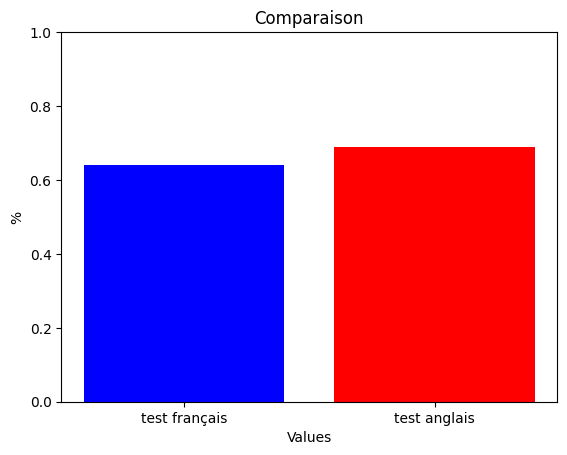

In [33]:
affichage(accuracy1, accuracy2)


Test du model bert-base-multilingual-uncased-sentiment

In [34]:
def tweet_test_uncased(logits):
    rep = logits.tolist()
    rep = rep[0]
    indice_max = rep.index(max(rep)) + 1
    if 0<= indice_max <= 2 :
        return 0
    else :
        return 4

In [35]:
def test_uncased_eng(df):
    count = 0
    df_cleaned = df.loc[:, "tweet"] = df["tweet"].apply(cleanText)
    ans = []
    for item in df_cleaned:
        text = item
        inputs = tokenizer_multi_lang_unca(text, return_tensors="pt")

        with torch.no_grad():
            outputs = model_multi_lang_unca(**inputs)

        logits = outputs.logits
        predicted_class = torch.argmax(logits).item()

        '''print(text)
        print(f"Raw logits: {logits}")
        print(f"Predicted sentiment class: {predicted_class + 1} (1 = worst, 5 = best)")'''
        count+=1
        print(count)
        ans.append(tweet_test_uncased(logits))
    return ans

In [36]:
def test_uncased_fr(df):
    count = 0
    df_cleaned = df.loc[:, "tweet_fr"] = df["tweet_fr"].apply(cleanText)
    ans = []
    for item in df_cleaned:
        text = item
        inputs = tokenizer_multi_lang_unca(text, return_tensors="pt")

        with torch.no_grad():
            outputs = model_multi_lang_unca(**inputs)

        logits = outputs.logits
        predicted_class = torch.argmax(logits).item()

        print(text)
        print(f"Raw logits: {logits}")
        print(f"Predicted sentiment class: {predicted_class + 1} (1 = worst, 5 = best)")
        count+=1
        print(count)
        ans.append(tweet_test_uncased(logits))
    return ans

In [37]:
ansFR_model_unca = test_uncased_fr(testFr_df[:1000])
ans_eng_model_unca = test_uncased_eng(testFr_df[:1000])

- Awww, c'est nul. Vous devriez avoir David Carr du troisième jour pour le faire. ;D
Raw logits: tensor([[ 3.5943,  1.3590, -0.1955, -1.9093, -2.0507]])
Predicted sentiment class: 1 (1 = worst, 5 = best)
1
est contrarié qu'il ne puisse pas mettre à jour son Facebook en le texto... et pourrait pleurer en conséquence École aujourd'hui aussi.
Raw logits: tensor([[ 1.7444,  2.0487,  1.1369, -1.2899, -2.7531]])
Predicted sentiment class: 2 (1 = worst, 5 = best)
2
J'ai plongé plusieurs fois pour la balle. A réussi à économiser 50% Le reste sortir des limites
Raw logits: tensor([[ 2.0902,  1.3219, -0.0275, -1.4187, -1.5458]])
Predicted sentiment class: 1 (1 = worst, 5 = best)
3
Tout mon corps se sent démangeant et comme sur le feu
Raw logits: tensor([[ 1.2276,  1.2339,  0.3354, -1.1528, -1.3035]])
Predicted sentiment class: 2 (1 = worst, 5 = best)
4
non, ce n'est pas du tout se comporter. Je suis fou. Pourquoi suis-je ici? Parce que je ne peux pas vous voir partout là-bas.
Raw logits: tensor(

In [38]:
ans1 = 0
for actual, predicted in zip(testFr_df["class"], ansFR_model_unca):
    if actual == predicted:
        ans1 += 1

accuracy1 = ans1 / testFr_df[:1000].shape[0]
print(accuracy1)


0.672


In [39]:
f1 = f1_score(testFr_df["class"][:1000], ansFR_model_unca[:1000], average="weighted")
print("F1-score:", f1)

F1-score: 0.6710407548411167


In [40]:
precision = precision_score(testFr_df["class"][:1000], ansFR_model_unca[:1000], average="weighted")
print("Precision:", precision)

Precision: 0.6740298845736672


In [41]:
ans2 = 0
for actual, predicted in zip(testFr_df["class"], ans_eng_model_unca):
    if actual == predicted:
        ans2 += 1

accuracy2 = ans2 / testFr_df[:1000].shape[0]
print(accuracy2)

0.68


In [42]:
f1 = f1_score(testFr_df["class"][:1000], ans_eng_model_unca[:1000], average="weighted")
print("F1-score:", f1)

F1-score: 0.6798962863967926


In [43]:
precision = precision_score(testFr_df["class"][:1000], ans_eng_model_unca[:1000], average="weighted")
print("Precision:", precision)

Precision: 0.6802335827232093


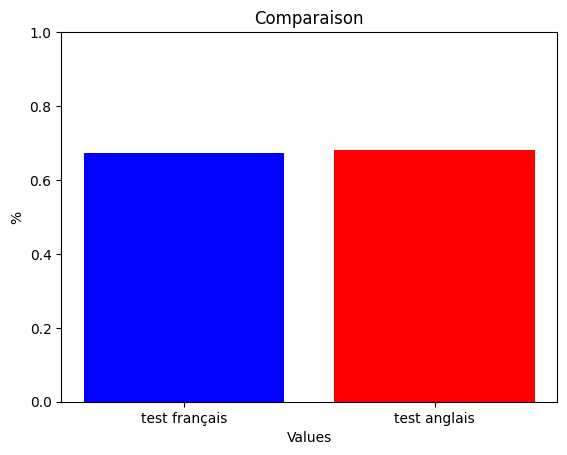

In [44]:
affichage(accuracy1, accuracy2)
